In [33]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [34]:
IMAGE_SIZE = 256
BATCH_SIZE = 32     #32 images
CHANNELS = 3
EPOCHS = 50

In [35]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE

)

Found 2152 files belonging to 3 classes.


In [36]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [37]:
len(dataset)

68

In [38]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 0 0 1 0 1 0 0 1 1 2 0 1 2 1 0 1 1 2 1 0 0 0 0 1 1 1 0 1 1 1]


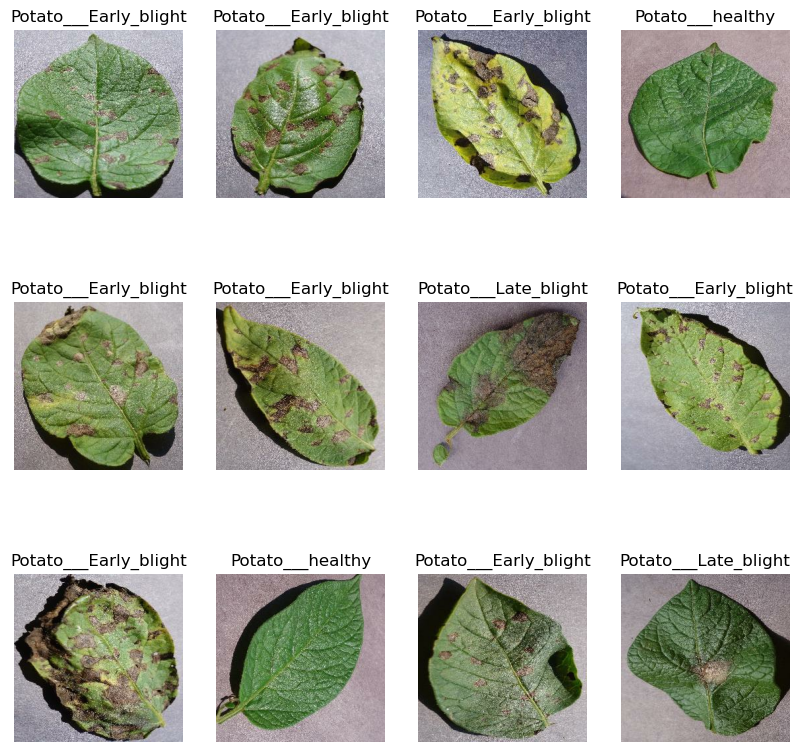

In [39]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [40]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

In [41]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [42]:
train_ds = dataset.take(54)
len(train_ds)

54

In [43]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [44]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [45]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [46]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [47]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [48]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [49]:
len(train_ds)

54

In [50]:
len(val_ds)

6

In [51]:
len(test_ds)

8

In [52]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [53]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [54]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [55]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
    
])

model.build(input_shape=input_shape)


C:\Users\msi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [56]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
model.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)

In [58]:
history = model.fit(
train_ds,
epochs = EPOCHS,
batch_size = BATCH_SIZE,
verbose = 1,
validation_data = val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 54s 876ms/step - accuracy: 0.4880 - loss: 0.9418 - val_accuracy: 0.6927 - val_loss: 0.8164
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 47s 875ms/step - accuracy: 0.6638 - loss: 0.7718 - val_accuracy: 0.8594 - val_loss: 0.4122
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 51s 958ms/step - accuracy: 0.7714 - loss: 0.5521 - val_accuracy: 0.8750 - val_loss: 0.2974
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 53s 971ms/step - accuracy: 0.8702 - loss: 0.3284 - val_accuracy: 0.9167 - val_loss: 0.2357
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 48s 894ms/step - accuracy: 0.8565 - loss: 0.3433 - val_accuracy: 0.8802 - val_loss: 0.3175
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 47s 865ms/step - accuracy: 0.8884 - loss: 0.2798 - val_accuracy: 0.9323 - val_loss: 0.1514
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 851ms/step - accuracy: 0.9358 - loss: 0.1701 - val_accuracy: 0.9323 - val_loss: 0.1574
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 45s 822ms/step - accuracy: 0.9365 - loss: 0.1645 - val_accu

In [59]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 267ms/step - accuracy: 0.9706 - loss: 0.0825


In [60]:
scores

[0.06041227653622627, 0.9765625]

In [61]:
history

In [62]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [63]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

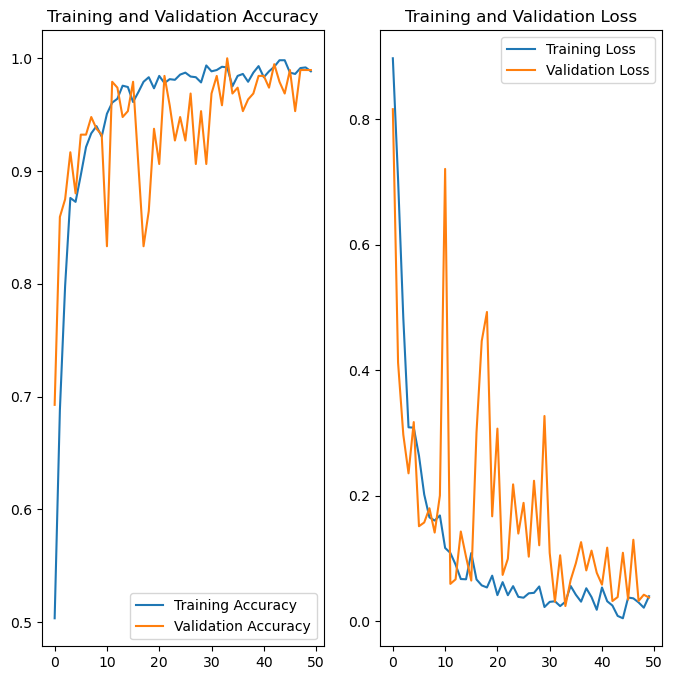

In [65]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label ="Validation Loss" )
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
predicted label: Potato___Late_blight


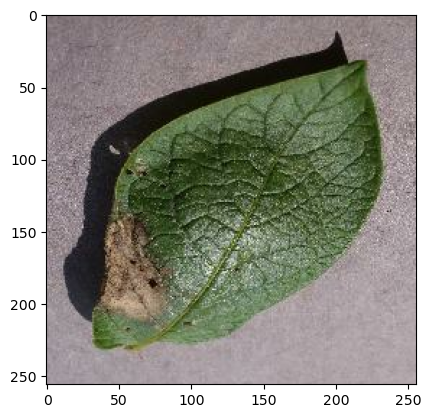

In [66]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])
    

In [67]:
batch_prediction[0]

array([1.2849629e-06, 7.1121275e-01, 2.8878599e-01], dtype=float32)

In [68]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) #create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


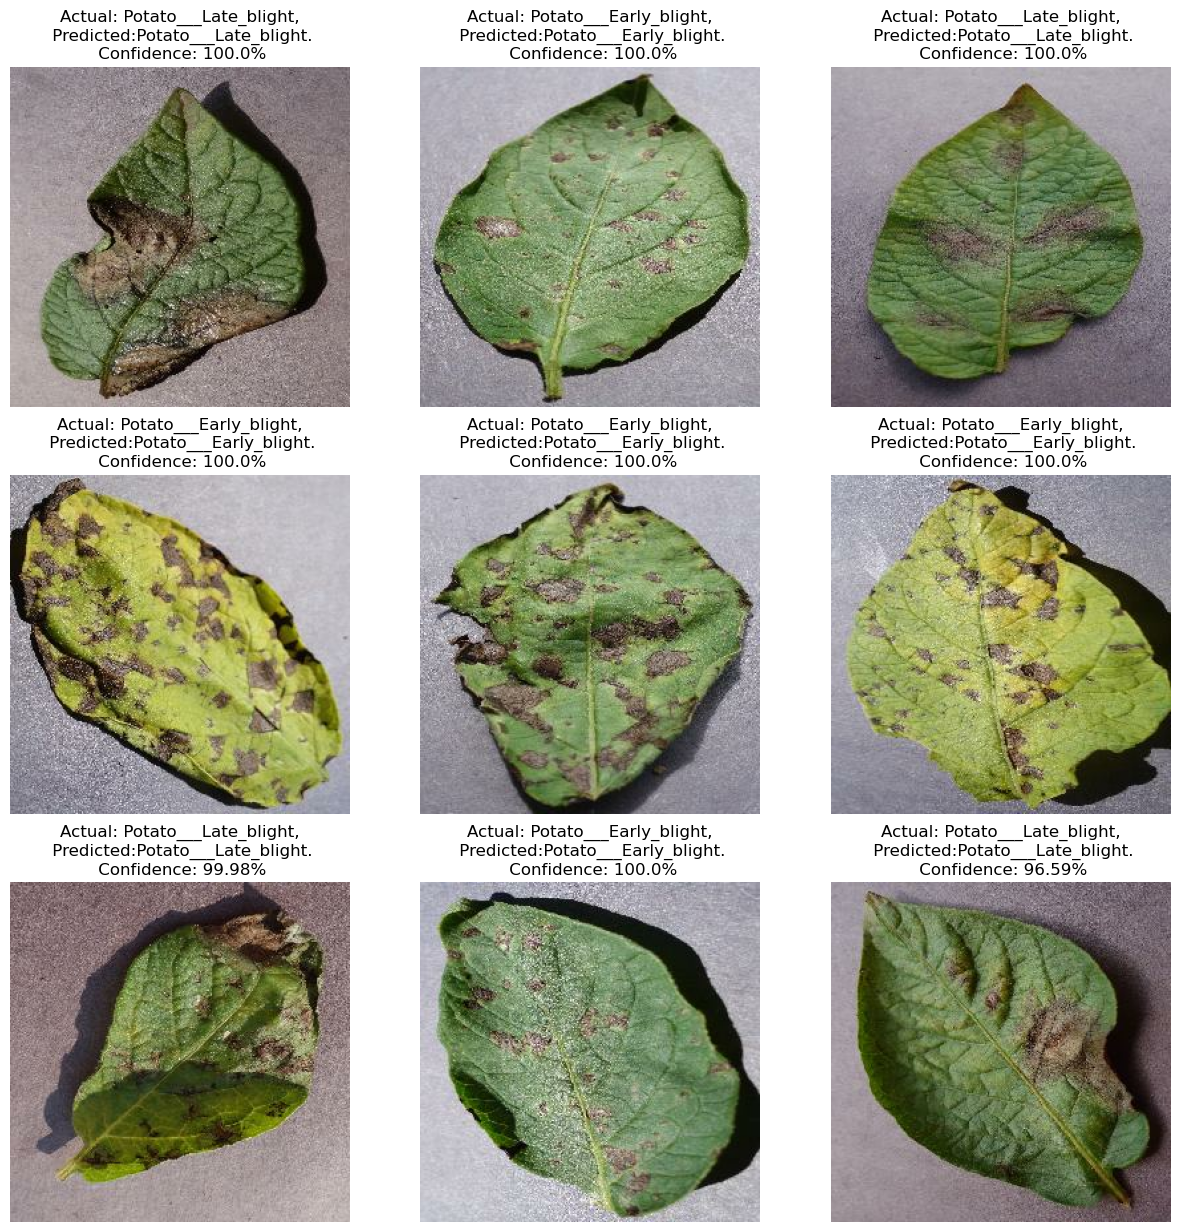

In [69]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted:{predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [82]:
export_path = 'C:/Users/msi/Desktop/Code/potato-disease/saved_models/potato_model/1'

In [83]:
tf.saved_model.save(model, export_path)

AssertionError: Tried to export a function which references an 'untracked' resource. TensorFlow objects (e.g. tf.Variable) captured by functions must be 'tracked' by assigning them to an attribute of a tracked object or assigned to an attribute of the main object directly. See the information below:
	Function name = b'__inference_signature_wrapper_serving_default_47914'
	Captured Tensor = <ResourceHandle(name="seed_generator_4/seed_generator_state/119", device="/job:localhost/replica:0/task:0/device:CPU:0", container="Anonymous", type="class tensorflow::Var", dtype and shapes : "[ DType enum: 9, Shape: [2] ]")>
	Trackable referencing this tensor = <tf.Variable 'seed_generator_4/seed_generator_state:0' shape=(2,) dtype=int64>
	Internal Tensor = Tensor("47876:0", shape=(), dtype=resource)

export_path = C:\Users\msi\AppData\Local\Temp\1



In [70]:
# model.save(f"../models/{model_version}.keras")

In [84]:

model.save(f"../models/1.keras")

In [87]:
# Load the model
loaded_model = tf.keras.models.load_model("../models/1.keras")


first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
predicted label: Potato___Early_blight


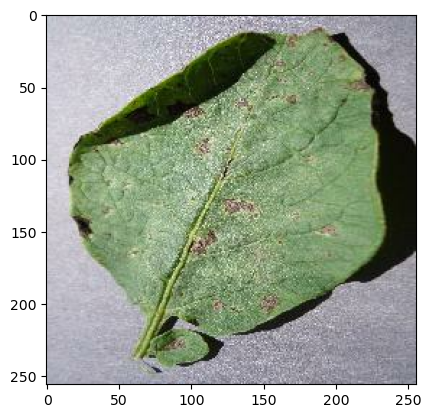

In [88]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    
    batch_prediction = loaded_model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])
    

In [5]:
import tensorflow as tf

# Load your Keras model
model = tf.keras.models.load_model("C:/Users/msi/Desktop/Code/potato-disease/models/1.keras")

# Save the model as a SavedModel format
model.export("C:/Users/msi/Desktop/Code/potato-disease/saved_model/1")


INFO:tensorflow:Assets written to: C:/Users/msi/Desktop/Code/potato-disease/saved_model/1\assets


INFO:tensorflow:Assets written to: C:/Users/msi/Desktop/Code/potato-disease/saved_model/1\assets


Saved artifact at 'C:/Users/msi/Desktop/Code/potato-disease/saved_model/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2007839277520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2007839279824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2007839280016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2007839281168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2007839281360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2007839281936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2007839282128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2007839282704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2007839280592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2007839283664: TensorSpec(shape=(), dtype=tf.resource, name=None)